In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
from data_process.shadow_render import render_shadow
import matplotlib.pyplot as plt

import torch
from ssn import ssn_dataset
from torchvision import transforms, utils
import numpy as np
from utils.net_utils import show_batch, show_light_batch
import numpy as np
from scipy.ndimage.filters import gaussian_filter
import torch
import torch.nn as nn
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt

# Testing relative vectors

In [3]:
# generate ibls(rotating around)
def to_mask(img):
    img = (img[:,:,0] + img[:,:,1] + img[:,:,2])/3.0
    img = img/np.max(img)
    return img

# relative_vec = np.array([0.108, 2.64, 1.8])
# ibl_img = to_mask(render_shadow(relative_vec))

# Render predictions  

In [4]:
from tqdm import tqdm
from PIL import Image
from ssn.ssn_dataset import Mask_Transform, IBL_Transform, ToTensor
import os 

def show_np(img):
    plt.figure()
    plt.imshow(img)

def to_one_batch(img_tensor):
    c,h,w = img_tensor.size()
    return img_tensor.view(1,c,h,w)

def to_numpy(one_batch):
    return one_batch[0].detach().cpu().numpy().transpose((1,2,0))

def real_to_mask(img):
    # print(np.max(img))
    h,w,c = img.shape
    mask = np.zeros((h,w,3), dtype=np.uint8)
    mask[:,:,0],mask[:,:,1],mask[:,:,2]  = img[:,:,3], img[:,:,3], img[:,:,3]
    
    mask_img = Image.fromarray(mask)
    new_h,new_w = 100, 100
    mask_np = np.array(mask_img.resize((new_h,new_w), Image.BILINEAR)) 
    
    mask = np.zeros((256,256,3),dtype=np.uint8)
    mask[(256-new_h)//2:(256-new_h)//2 + new_h,(256-new_w)//2:(256-new_w)//2 + new_w] = mask_np
    
    return mask

In [ ]:
import random
from scipy.ndimage.filters import gaussian_filter
output_folder = '/home/ysheng/Documents/adobe_shadow_net/testing_lights/'
output_folder = '/home/ysheng/Dataset/soft_shadow/train/airplane_0330_normalize/imgs'

prediction_result_folder = '/home/ysheng/Documents/adobe_shadow_net/results/animations/'

testing_fname = '/home/ysheng/Dataset/soft_shadow/real_human_testing_set/10944340-young-man-standing.png'
testing_img = Image.open(testing_fname)
testing_img = real_to_mask(np.array(testing_img))

testing_ibl_fnames = [f for f in os.listdir(output_folder) if f.find("light") != -1]
print(len(testing_ibl_fnames))

counter = 1

img_trnsf = transforms.Compose([
    Mask_Transform(),
    ToTensor()
])
ibl_trnsf = transforms.Compose([
    IBL_Transform(),
    ToTensor()
])

random.shuffle(testing_ibl_fnames) 
counter = 0

for ibl_file in tqdm(testing_ibl_fnames):
    prefix = os.path.splitext(ibl_file)[0]
    out_file = '{}.png'.format(prefix)
    predict_fname = os.path.join(prediction_result_folder, out_file)
    
    ibl_img = np.array(Image.open(os.path.join(output_folder, ibl_file)))
    shadow = predict(testing_img, np.array(ibl_img))
    
    ibl_img = ibl_img/np.max(ibl_img)
    ibl_img = (ibl_img[:,:,0] + ibl_img[:,:,1] + ibl_img[:,:,2])/3.0
    ibl_img = gaussian_filter(ibl_img, sigma=20)
    show_np(ibl_img)
    show_np(shadow)
    
    counter += 1
    if counter > 5:
        break

# Make animations

norm: group_norm bilinear: True activation: relu
Device:  cuda:0


100%|██████████| 512/512 [01:38<00:00,  5.22it/s]


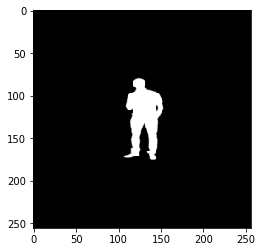

In [15]:
from valid_relight_ssn import render_animation
import numpy as np
from PIL import Image

testing_fname = '/home/ysheng/Dataset/soft_shadow/real_human_testing_set/10944340-young-man-standing.png'
testing_img = Image.open(testing_fname)
real_human = real_to_mask(np.array(testing_img))
show_np(real_human)
output_folder = 'results/animations/experiments'
os.makedirs(output_folder, exist_ok=True)
render_animation(real_human, output_folder)

# training_human = '/home/ysheng/Dataset/soft_shadow/train/simulated_combine_female_long_fullbody_bridget8_wildwind_ssradclosedrobe_Base_Pose_Standing_A/imgs/0000000_mask.png'
# testing_img = np.array(Image.open(training_human))
# show_np(testing_img)
# output_folder = 'results/animations/training_human_own_light'
# os.makedirs(output_folder, exist_ok=True)
# render_animation(testing_img, output_folder)

# training_bottle = '/home/ysheng/Dataset/soft_shadow/train/bottle_0052_normalize/imgs/0000000_mask.png'
# testing_img = np.array(Image.open(training_bottle))
# show_np(testing_img)
# output_folder = 'results/animations/training_simple_obj'
# os.makedirs(output_folder, exist_ok=True)
# render_animation(testing_img, output_folder)